In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pickle


In [110]:
tokens_for_model = pd.read_csv('tokensForModel.csv',sep=',')

In [111]:
tokens_for_model=tokens_for_model.loc[tokens_for_model['cluster']==2]

In [112]:
tokens_for_model

,symbol,cluster
12,FANTOM,2
13,FETCH_AI,2
14,FLOKI,2
16,GALA,2
29,THETA,2
31,XRP,2


In [113]:
lsToken_for_model=tokens_for_model['symbol'].to_list()
lsToken_for_model

['FANTOM', 'FETCH_AI', 'FLOKI', 'GALA', 'THETA', 'XRP']

In [114]:
tokensCleaned  = pd.read_csv('tokensCleaned.csv',sep=';')

In [115]:
tokensCleaned = tokensCleaned.loc[tokensCleaned['symbol'].isin(lsToken_for_model)]

In [116]:
filter=tokensCleaned['symbol']==lsToken_for_model[0]
firtTokenForModel=tokensCleaned[filter]
firtTokenForModel.head()


,date,symbol,open,high,low,close,volume,marketCap
20062,2019-06-15,FANTOM,0.027546,0.030119,0.026527,0.027060,22170504.53,4.907752e+07
20063,2019-06-16,FANTOM,0.027060,0.027504,0.026224,0.027037,16752516.81,4.903613e+07
20064,2019-06-17,FANTOM,0.026979,0.029027,0.026309,0.026873,32656791.83,4.873807e+07
20065,2019-06-18,FANTOM,0.026859,0.028063,0.026008,0.027648,19829962.60,5.014330e+07
20066,2019-06-19,FANTOM,0.027619,0.029946,0.027619,0.028272,19297573.70,5.127580e+07


In [117]:
data = firtTokenForModel.copy()
data.set_index('date',inplace=True)
data.index = pd.to_datetime(data.index)
data.drop(['symbol'], axis=1, inplace=True)
data.sort_index(inplace=True)
data.head()

,open,high,low,close,volume,marketCap
date,,,,,,
2019-06-15,0.027546,0.030119,0.026527,0.027060,22170504.53,4.907752e+07
2019-06-16,0.027060,0.027504,0.026224,0.027037,16752516.81,4.903613e+07
2019-06-17,0.026979,0.029027,0.026309,0.026873,32656791.83,4.873807e+07
2019-06-18,0.026859,0.028063,0.026008,0.027648,19829962.60,5.014330e+07
2019-06-19,0.027619,0.029946,0.027619,0.028272,19297573.70,5.127580e+07


## modelamos un lstm

In [118]:
token_scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = token_scaler.fit_transform(data)


In [119]:
from sklearn.decomposition import PCA

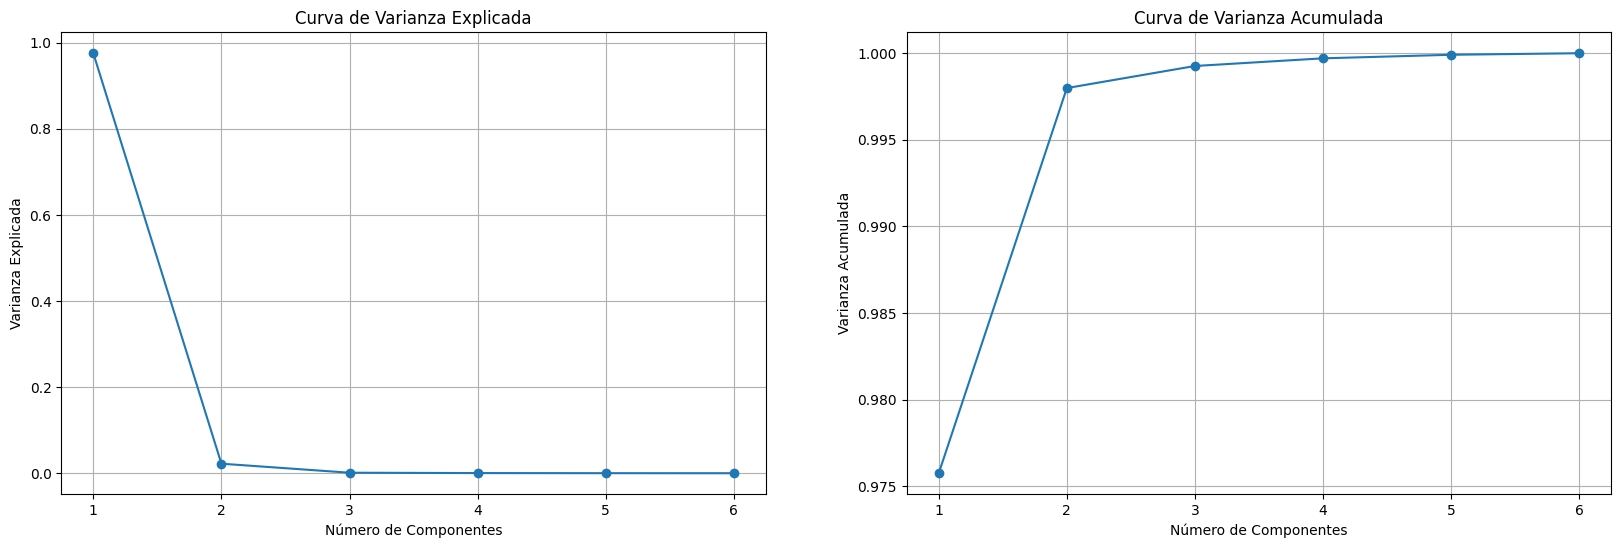

In [120]:
pca = PCA().fit(data_scaled)
fig,ax = plt.subplots(figsize=(20, 6),ncols=2, nrows=1)
ax[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Número de Componentes')
ax[0].set_ylabel('Varianza Explicada')
ax[0].set_title('Curva de Varianza Explicada')
ax[0].grid(True)
ax[1].plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Número de Componentes')
ax[1].set_ylabel('Varianza Acumulada')
ax[1].set_title('Curva de Varianza Acumulada')
ax[1].grid(True)
plt.show()

In [121]:
n_components = pca.explained_variance_ratio_[pca.explained_variance_ratio_.cumsum() < 0.99].shape[0]
print(f'Número de componentes para explicar el 95% de la varianza: {n_components}')

Número de componentes para explicar el 95% de la varianza: 1


significa que con los demas modelos tendremso que redecir su dimensionalidad a 1 y usar un minmaxscaler debido qeu cada token tendra sus cualidades que no son replicables con entre ellos

In [122]:
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [124]:
def create_dataset(X, y, time_steps=1,n_future=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - n_future):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps:i + time_steps + n_future])
    return np.array(Xs), np.array(ys)

In [125]:
time_steps = 200
n_future = 80

In [126]:
X, y = create_dataset(data_pca, data_pca, time_steps,n_future)

In [127]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [128]:

model = Sequential()
model.add(LSTM(400, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

/home/dev/workspace/tfml/.conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [129]:
model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1545/1545 - 94s - 61ms/step - loss: 0.0956
Epoch 2/100
1545/1545 - 104s - 67ms/step - loss: 0.1707
Epoch 3/100
1545/1545 - 108s - 70ms/step - loss: 0.0966
Epoch 4/100
1545/1545 - 109s - 70ms/step - loss: 0.1490
Epoch 5/100
1545/1545 - 109s - 70ms/step - loss: 0.0811
Epoch 6/100
1545/1545 - 109s - 70ms/step - loss: 0.0705
Epoch 7/100
1545/1545 - 109s - 71ms/step - loss: 0.0635
Epoch 8/100
1545/1545 - 109s - 71ms/step - loss: 0.0582
Epoch 9/100
1545/1545 - 109s - 71ms/step - loss: 0.0530
Epoch 10/100
1545/1545 - 110s - 71ms/step - loss: 0.0511
Epoch 11/100
1545/1545 - 110s - 71ms/step - loss: 0.0482
Epoch 12/100
1545/1545 - 109s - 71ms/step - loss: 0.0537
Epoch 13/100
1545/1545 - 109s - 71ms/step - loss: 0.0609
Epoch 14/100
1545/1545 - 110s - 71ms/step - loss: 0.0831
Epoch 15/100
1545/1545 - 110s - 71ms/step - loss: 0.0600
Epoch 16/100
1545/1545 - 110s - 71ms/step - loss: 0.0952
Epoch 17/100
1545/1545 - 110s - 71ms/step - loss: 0.0976
Epoch 18/100
1545/1545 - 109s - 71ms/step

In [130]:
pickle.dump(model, open('model_first.pkl','wb'))

In [131]:
model = pickle.load(open('model_first.pkl','rb'))

realizamos este proceseso para los demas tokens menos 2 para realizar dos test

In [132]:
for i in range(1, len(lsToken_for_model)-2):
    filter=tokensCleaned['symbol']==lsToken_for_model[i]
    tokenForModel=tokensCleaned[filter].copy()
    tokenForModel.set_index('date',inplace=True)
    tokenForModel.index = pd.to_datetime(tokenForModel.index)
    tokenForModel.drop(['symbol'], axis=1, inplace=True)
    tokenForModel.sort_index(inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(tokenForModel)
    pca = PCA(n_components=n_components)
    tokenForModel_pca = pca.fit_transform(scaler.transform(tokenForModel))

    X, y = create_dataset(tokenForModel_pca, tokenForModel_pca, time_steps,n_future)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    model.fit(X, y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


1650/1650 - 117s - 71ms/step - loss: 0.0323
Epoch 2/100
1650/1650 - 117s - 71ms/step - loss: 0.0123
Epoch 3/100
1650/1650 - 117s - 71ms/step - loss: 0.0068
Epoch 4/100
1650/1650 - 117s - 71ms/step - loss: 0.0052
Epoch 5/100
1650/1650 - 117s - 71ms/step - loss: 0.0056
Epoch 6/100
1650/1650 - 117s - 71ms/step - loss: 0.0055
Epoch 7/100
1650/1650 - 117s - 71ms/step - loss: 0.0070
Epoch 8/100
1650/1650 - 117s - 71ms/step - loss: 0.0039
Epoch 9/100
1650/1650 - 117s - 71ms/step - loss: 0.0040
Epoch 10/100
1650/1650 - 117s - 71ms/step - loss: 0.0038
Epoch 11/100
1650/1650 - 116s - 71ms/step - loss: 0.0035
Epoch 12/100
1650/1650 - 116s - 70ms/step - loss: 0.0047
Epoch 13/100
1650/1650 - 116s - 70ms/step - loss: 0.0029
Epoch 14/100
1650/1650 - 115s - 70ms/step - loss: 0.0037
Epoch 15/100
1650/1650 - 115s - 70ms/step - loss: 0.0029
Epoch 16/100
1650/1650 - 115s - 70ms/step - loss: 0.0027
Epoch 17/100
1650/1650 - 115s - 70ms/step - loss: 0.0049
Epoch 18/100
1650/1650 - 115s - 70ms/step - loss: 0.

In [133]:
pickle.dump(model, open('model_trained.pkl','wb'))